# Earthquake Damage Prediction

Let's look at the data.

## Notes on the data

* Are some of them collinear? E.g. is `has_superstructure_other` always 1 if one of the other `has_superstructure` variables is turned on?

Let's go through a nice and simple model.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

In [5]:
sns.set()

In [61]:
DATA_DIR = Path("/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/data")
SUBMISSIONS_DIR = Path(
    "drive/MyDrive/Work/Delivery/Current/Earthquake_damage/submissions"
)

In [7]:
train_values = pd.read_csv(DATA_DIR / "train_values.csv", index_col="building_id")
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv", index_col="building_id")

In [8]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

These are imported as floats but may make sense to change them to ints or categories??

## Basic EDA

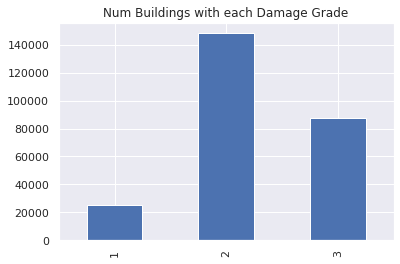

In [9]:
(
    train_labels.damage_grade.value_counts()
    .sort_index()
    .plot.bar(title="Num Buildings with each Damage Grade")
)

In [10]:
# Just using a subsection to make a quick prediction
selected_features = [
    "foundation_type",
    "area_percentage",
    "height_percentage",
    "count_floors_pre_eq",
    "land_surface_condition",
    "has_superstructure_cement_mortar_stone",
]

train_values_subset = train_values[selected_features]

KeyboardInterrupt: ignored

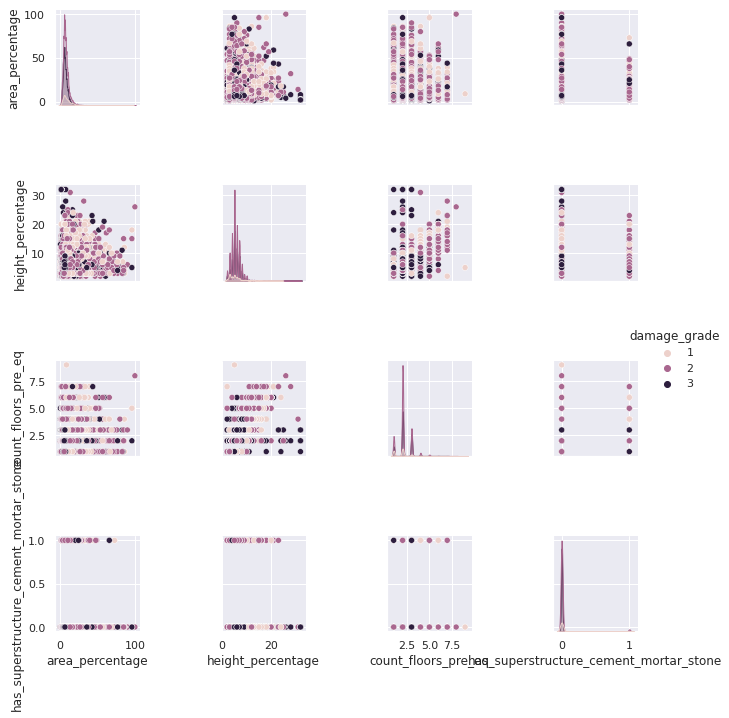

In [11]:
# Quick look at relationship between numeric features and labels
sns.pairplot(train_values_subset.join(train_labels), hue="damage_grade")

## Pre-processing

Amazed how this is just one line...

In [12]:
train_values_subset = pd.get_dummies(train_values_subset)

## Build First Model

We'll use a random forest since these are often good first models... though i think it makes more sense to build an even more basic model

In [14]:
# Completely unnecessary for tree based models... but good to use anyway
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

In [15]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=2018))
pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2018,
                                        verbose=0, warm_start=False))],
         verbose=F

In [24]:
# Test multiple different models using GridSearch
param_grid = {
    "randomforestclassifier__n_estimators": [50, 100],
    "randomforestclassifier__min_samples_leaf": [1, 5],
}

gs = GridSearchCV(pipe, param_grid, cv=5, verbose=3, n_jobs=-1)

In [25]:
gs.fit(train_values_subset, train_labels.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [26]:
# See best parameters
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [27]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2018,
                                        verbose=0, warm_start=False))],
         verbose=F

In [28]:
from sklearn.metrics import f1_score

# Note we use predict and NOT predict_proba
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average="micro")

0.5894183061461775

Sidenote: amazing that you can use the trained GridSearch (and I assume also RandomizedSearch) instances as models themselves (since they include all the preprocessing you need to do too!) and that they automatically pick the best model. So cool.

## Let's Predict and Submit

Let's see what the class predictions are, not the class probabilities (since this is multi-class classification and the submissions are supposed to be ints).

In [43]:
test_values = pd.read_csv(DATA_DIR / "test_values.csv", index_col="building_id")

In [44]:
test_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [45]:
len(train_values)

260601

In [46]:
# Test set is 25% of total data available
len(test_values) / (len(train_values) + len(test_values))

0.2500021584659351

In [47]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

In [48]:
predictions = gs.predict(test_values_subset)

In [49]:
# A 1D array of integers
predictions

array([3, 2, 2, ..., 2, 2, 2])

## Save Submission

We can use the column name and index from the submission format to ensure our predictions are in the correct form.

In [50]:
submission_format = pd.read_csv(
    DATA_DIR / "submission_format.csv", index_col="building_id"
)

In [51]:
my_submission = pd.DataFrame(
    data=predictions, columns=submission_format.columns, index=submission_format.index
)

In [52]:
my_submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,2
...,...
310028,3
663567,2
1049160,2


We need to save it and upload it as `submission.csv`.

In [60]:
my_submission.to_csv("submission.csv")

In [63]:
!ls

drive  sample_data  submission.csv


In [65]:
from google.colab import files

submission_file = SUBMISSIONS_DIR / "26-1_random_forest_basline_model.csv"

my_submission.to_csv(submission_file)
# files.download(submission_file)

# Questions

* Change the dtypes of all the columns to categories or ints? They are all floats atm.
* Should we not drop a column in `pd.get_dummies`??
* Build a model with the same class balance to see what an intelligent very basic model would achieve.
* Build the model using:
 * `Pipeline` class rather than `make_pipeline`
 * `RandomizedSearch` instead of `GridSearch`

# Notes

* Imbalanced classification problem